# Determining Ford GoBike User Trip Pattern 
## by Tonima Ferdous

## Investigation Overview

In this investigation, I wanted to determine the trip pattern of Ford GoBike users by exploring a dataset of February 2019. Different features of the riders, such as, age, gender, and subscription are analyzed to identify their influence on the trips. Investigation was also conducted on trip stations, duration, and timing on weekdays and weekends.

## Dataset Overview

The dataset provides bike share statistics of approximately 183,000 individual rides made in California's San Francisco Bay Area. The data includes durations, schedules, and station locations for various user types, age groups, and genders. Around 9,000 data points are excluded from the dataset due to inconsistencies or missing information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
tripdata = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# copy the original dataset for performing data wrangling 
# this is a safety measure so that we don't lose any original data 
td_clean = tripdata.copy() 

In [4]:
# convert 'duration_sec' to duration_min' 
# this is not a quality of tidiness issue
# this is done to make the exploration easy to comprehend 
td_clean['duration_min'] = (td_clean['duration_sec'] / 60).round(2)

In [5]:
# extract days from the 'start_time' column to create a 'start_time_day' column
td_clean['start_time_day'] = pd.to_datetime(td_clean['start_time']).dt.strftime('%A')
# extract hours from the 'start_time' column to create a 'start_time_hour' column
td_clean['start_time_hour'] = pd.to_datetime(td_clean['start_time']).dt.hour
# extract hours from the 'end_time' column to create a 'end_time_hour' column
td_clean['end_time_hour'] = pd.to_datetime(td_clean['end_time']).dt.hour

In [6]:
# calculate age of the members from 'member_birth_year' column
td_clean['age'] = 2019 - td_clean['member_birth_year']

In [7]:
# replace null values with 'None' in 'member_gender' column
td_clean['member_gender'] = td_clean['member_gender'].astype(object).where(pd.notnull(td_clean['member_gender']), None)

In [8]:
# fix the data types for the following columns 
td_clean['start_station_id'] = td_clean['start_station_id'].astype(str)
td_clean['end_station_id'] = td_clean['end_station_id'].astype(str)
td_clean['bike_id'] = td_clean['bike_id'].astype(str)

In [9]:
# drop unwanted columns 
td_clean.drop(axis=1, columns=['duration_sec', 'start_time', 'end_time', 'member_birth_year'], inplace=True)

In [10]:
# avoid the entries where age is over 100 and duration_min is also over 100
# and create a new dataframe for the rest of the research 
df1 = td_clean.loc[td_clean['age']<100]
df1 = df1.loc[df1['duration_min']<100]
# reset the index
df1 = df1.reset_index(drop = True)

In [11]:
# convert the 'start_time_day' column from a plain object type into an ordered categorical type
start_time_day_classes = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dayclasses = pd.api.types.CategoricalDtype(ordered=True, categories=start_time_day_classes)
df1.start_time_day = df1.start_time_day.astype(dayclasses)

## User Types by Age and Gender

There are 89.2% subscribed members and 10.8% causal customers. Male, female, and other gender are 74.6%, 23.3%, and 2.1%, respectively. By other gender, we are assuming that those riders did not disclose their sex during the documentation process.<br>
The below plot portrays a profile of the riders by comparing age, gender, and user types. There is no strong influence of age, irrespective of males and females, on the subscription. The median values of age are 31 and 32 for females and males, respectively, for both user types. However, the other gender displays a greater meadian age (around 35). Considering the mean age (34 years) of the members, it can be commented that the young and environmentally concious workforce prefers to use bikes in San Francisco.

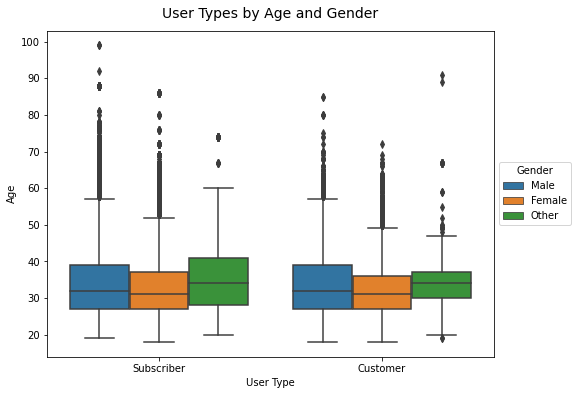

In [12]:
plt.figure(figsize = [8,6])
ax = sb.boxplot(x= 'user_type', y= 'age', hue = 'member_gender', data= df1,
                 order=['Subscriber', 'Customer'])
plt.title('User Types by Age and Gender', fontsize=14, y=1.02)
plt.xlabel('User Type')
plt.ylabel('Age')
plt.legend(title='Gender', loc = 6, bbox_to_anchor = (1.0, 0.5))
plt.show();

## Age and Duration Correlation

In comparing age with trip duration, we observe an inverse relationship. Duration of bike rides decreases in general as age increases, as expected. Most of the data fall in the large blob between 18 and 60 years of age and 1 and 25 minutes of trip duration. 

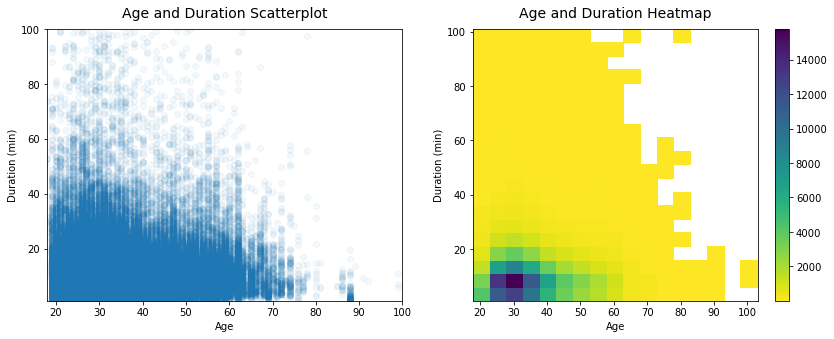

In [13]:
plt.figure(figsize = [14, 5])

plt.subplot(1, 2, 1)
plt.scatter(data = df1, x = 'age', y = 'duration_min', alpha=1/20);
plt.xlim([18, 100])
plt.ylim([1, 100])
plt.xlabel('Age')
plt.ylabel('Duration (min)')
plt.title('Age and Duration Scatterplot', fontsize = 14, y = 1.02);

plt.subplot(1,2,2)
bins_x = np.arange(18, 99+5, 5)
bins_y = np.arange(1, 99+5, 5)
plt.hist2d(data = df1, x = 'age', y = 'duration_min', cmin=0.5, cmap='viridis_r', bins = [bins_x, bins_y])
plt.colorbar()
plt.xlabel('Age')
plt.ylabel('Duration (min)');
plt.title('Age and Duration Heatmap', fontsize = 14, y = 1.02);

## Trip by Days and Hours

The plots show significant difference in bike ride usage during weekdays and weekend. GoBike trip frequency is highest on Thursdays, followed by Tuesdays and Wednesdays, respectively. GoBike is less popular during the weekends. The number of trips taken on Thursdays is approximately 55% higher than Sundays.<br>
The start time histograms are bimodal for the weekdays. There are spikes in 8 am and 5 pm, generally, same to the office hours. Many riders use GoBikes to fulfill their last mile commutes to offices or universities, with ride-sharing frequency peaking between 8 am-9 am and 5 pm-6 pm.<br>
On the other hand, start time histograms for the weekends are unimodal, with a peak between 1 pm and 2 pm. Riders choose to rent bikes mostly between 9 am and 7 pm on Sundays and Saturdays. Moreover, the difference between start hours are insignificant, which means, bikes are rented throughout the day.

In [14]:
# preparatory step
start_time_day_order = df1['start_time_day'].value_counts().index

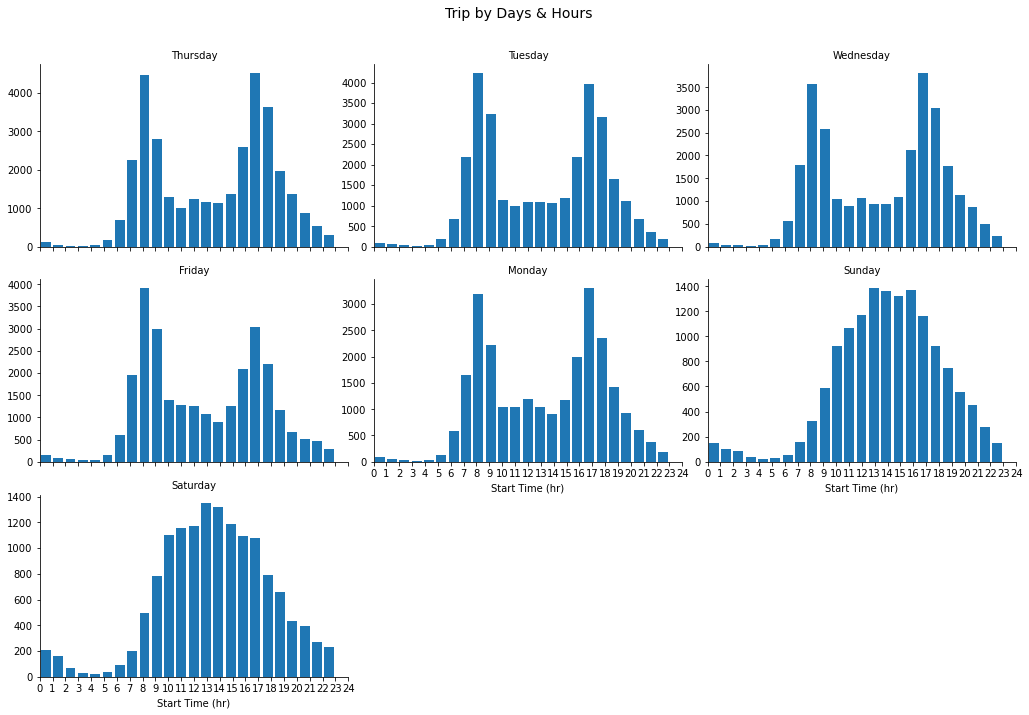

In [15]:
g = sb.FacetGrid(data = df1, col = 'start_time_day', col_order = start_time_day_order, col_wrap = 3, height = 4, aspect = 2, sharey=False, margin_titles = True)
g.map(plt.hist, 'start_time_hour', bins = 24, rwidth = 0.8)
g.set(xlim=(0, 24), xticks=np.arange(0, 25, 1))
g.set_axis_labels('Start Time (hr)', '')
g.fig.set_size_inches(14, 10)
g.set_titles('{col_name}')
g.fig.subplots_adjust(top = 0.9)
g.fig.suptitle('Trip by Days & Hours', fontsize = 14);

## Users Takes Longer Trips on Weekends

Higher trip durations are observed  during the weekends. The mean duration is highest on Saturdays and Sundays between 4 am and 5 pm, about 16 to 12 minutes. It can be assumed that, during weekends, users bike to places other than their works and study, and spend more time on the road. Among the working days, Mondays and Thursdays have higher trip durations, about 10 to 14 minutes. Although Mondays have the lowest trips taken (14.6%) in the weekdays, frequecies of 12 minutes trips are much higher. Our interpretation is that Mondays are likely the day when people are least organized as they return after the weekend and might take more time biking to workplaces. People get progressively readier to use the service during the week.

In [16]:
# preparatory steps
df_mean = pd.DataFrame(df1.groupby(['start_time_day', 'start_time_hour']).mean()['duration_min'])
df_mean = df_mean.reset_index()
df_mean.start_time_day = df_mean.start_time_day.astype(dayclasses)

df_mean = df_mean.pivot_table(values = 'duration_min', index = 'start_time_day', columns = 'start_time_hour')

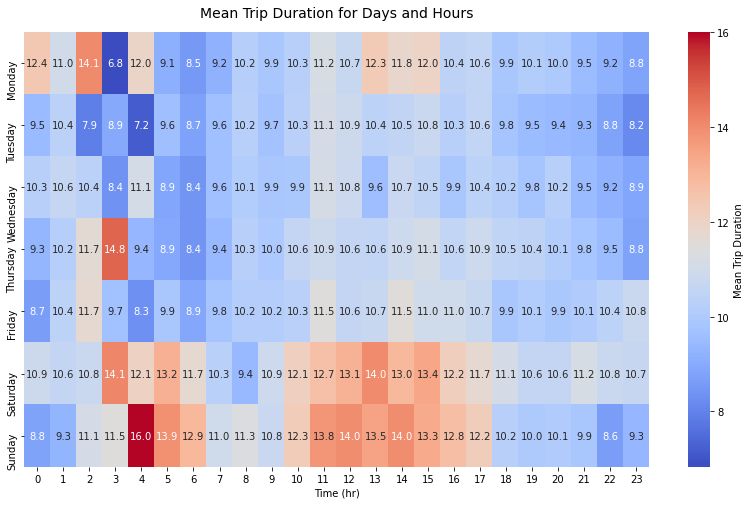

In [17]:
plt.figure(figsize = [14,8])
sb.heatmap(df_mean, annot = True, fmt = '.1f', cbar_kws = {'label':'Mean Trip Duration'}, cmap = 'coolwarm')
plt.xlabel('Time (hr)')
plt.ylabel('')
plt.title('Mean Trip Duration for Days and Hours', fontsize = 14, y = 1.02);

## Customers Take Longer Trips than Subscribers

Although the quantity of subscribers is 87.8% larger than the customers, customers have a higher trip duration than subscribers in avarage. Specially, on Saturdays and Sundays casual riders are found to bike longer than other days of the week. We assume that subscribed riders follow a regular schedule for commuting. Therefore, their trip durations are more or less the same through out the month. On the other hand, riders who do not subscribed to the plan, are occasional users of GoBike. They rent bikes for special schedules which are likely for long hours. Customers of all three gender types are found to go along with the same trend. 

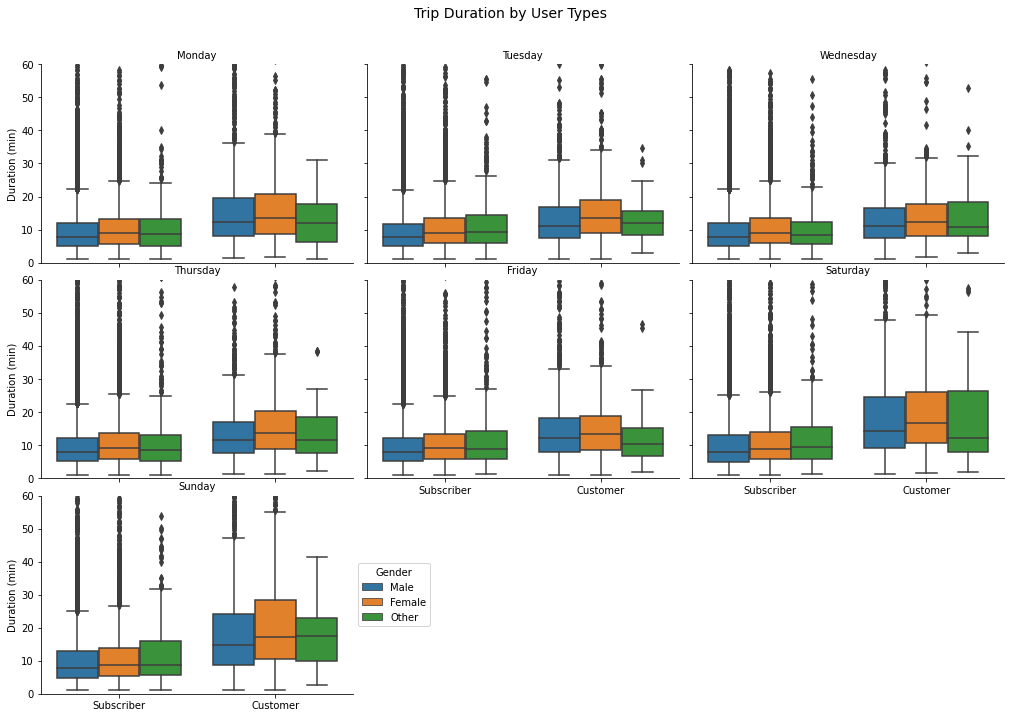

In [18]:
g = sb.catplot(x = 'user_type', y = 'duration_min', hue = 'member_gender',
                col = 'start_time_day',
                data = df1, kind = 'box', col_wrap = 3, legend = False);
g.set(ylim = (0, 60))
g.fig.set_size_inches(14, 10);
g.set_axis_labels('', 'Duration (min)')
g.set_xticklabels(['Subscriber', 'Customer'])
g.set_titles('{col_name}')
plt.legend(title ='Gender', loc = 6, bbox_to_anchor = (1.0, 0.5))
g.fig.subplots_adjust(top = 0.9)
g.fig.suptitle('Trip Duration by User Types', fontsize = 14);

## Females Take Longer Trips than Males

Interestingly, female riders renting bikes for long durations, although the quantity of male riders is 68.7% higher than the females. Particularly, on the weekends, females are observed biking for long hours. One assumption is that, female bikers usually take a little longer to bike the same distance compared to the males, and their trip duration goes up. Moreover, females might use bikes to trip more places—not only commute to work or school—they might run errands in bike.

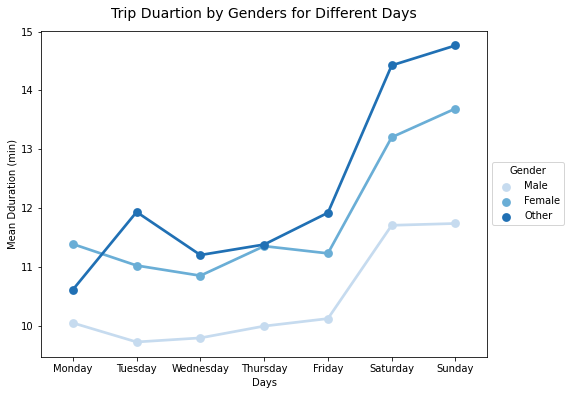

In [19]:
plt.figure(figsize = [8,6])
sb.pointplot(data = df1, x = 'start_time_day', y = 'duration_min', hue = 'member_gender', palette = 'Blues', ci = None)
plt.ylabel('Mean Dduration (min)')
plt.xlabel('Days')
plt.legend(title='Gender', loc = 6, bbox_to_anchor = (1.0, 0.5))
plt.title('Trip Duartion by Genders for Different Days', fontsize = 14, y = 1.02)
plt.show();

## Trip Duration by Top Stations

There are 329 unique start stations in the dataset. GoBike is popular among office commuters working with tech companies like Uber, Twitter located at Market Street, San Francisco. Other popular riding stations are located near major public transport hubs i.e. Caltrain Train Station, San Francisco Ferry Building (Harry Bridges Plaza) and The Embarcadero at Sansome St. The bike share system is popular among those who commute from outside of the city for work.<br>
For each of the top 10 start stations, the median duration of bike trips is longer for customers than subscribers. Also, for each station, the interquartile range, which approximates the trip length variability, is larger for the customers. This tells us that, typically, customers use the bikes longer, with greater variability in times, than subscribers. Trip durations in the stations are between 7 to 15 minutes for the subscribers and 8 to 30 minutes for the customers, ignoring the high-value outliers.

In [20]:
# top ten start stations
top_start_station = df1.start_station_name.value_counts()[:10].index
# limit analysis to a dataframe containing only the top ten start stations
top_station_df = df1[df1.start_station_name.isin(top_start_station)].copy()

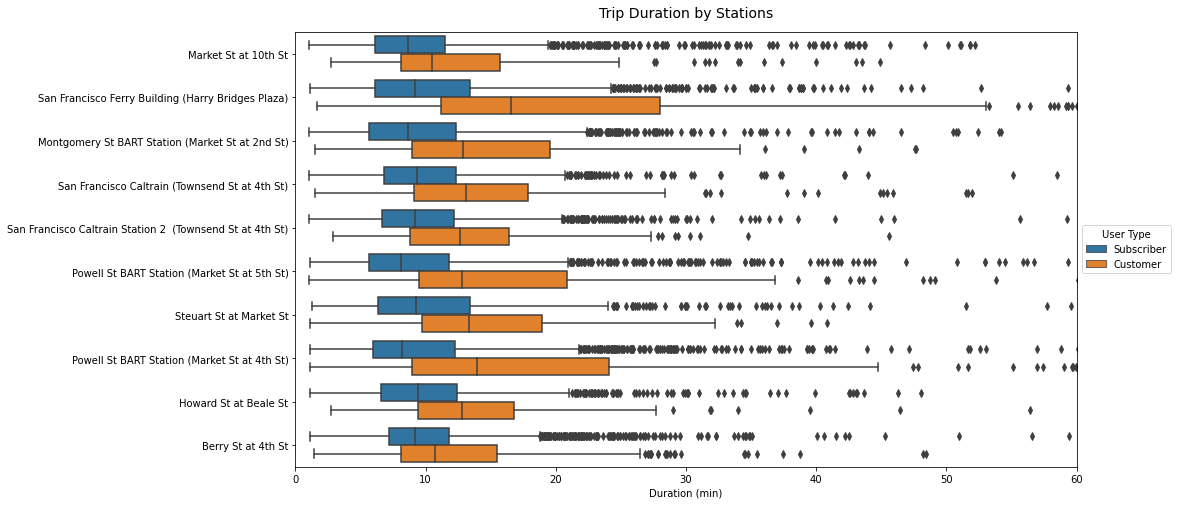

In [21]:
plt.figure(figsize = [14,8])
sb.boxplot(data = top_station_df, x='duration_min', y='start_station_name', hue = 'user_type', orient = 'h')
plt.xlim(0, 60)
plt.title('Trip Duration by Stations', fontsize = 14, y = 1.02)
plt.xlabel('Duration (min)')
plt.ylabel('')
plt.legend(title='User Type', loc = 6, bbox_to_anchor = (1.0, 0.5));